# Geospatial Software Engineer Internship (Aug-Sep 2021)

Hary Koido-Bunt

The data for the task is available to download [here](https://www.dropbox.com/sh/j5zipvhhvwrf3ks/AABZ_woZ9LVXg1Br5HTWT14Na?dl=0). (Local Copy in HKB Jobs Local Copy)

In [1]:
# Imports. Run using Python 3.7 on Windows 10 machine
import os
import numpy as np
import fiona
import rasterio
import rasterio.mask
from rasterio.plot import show
import glob
import matplotlib.pyplot as plt
import geopandas as gpd
from descartes import PolygonPatch
import rasterio.plot
import matplotlib
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# runs without this, but just for reference, 'task-data' folder in this dir
# os.chdir(r'C:\Users\Harry\OneDrive\Desktop\Life Admin\Jobs_Local_Copy\_Interview\Geospatial Software Engineer - Risk Mapping')

# GLOBAL RULES/ASSUMPTIONS
# - ignore NaN values between two bands with discrepancies (if Nan in one, Nan in both)
# - assuming B2 is first item in raster (could plot and verify but time)
# - did not bother to take a subset and did everything in memory because example data is small.
#    If a pipeline for lots of data, would make absolutely everything into functions or even classes
# - the kmeans learner, there are only 2 distinct classes, and they are the two we want (forested/bare). Not elbow/silhouette plotting

In [2]:
data_dir = os.path.join(os.getcwd(),'task-data')  # dir containing: script, CV letter, data folder
aoi = fiona.open(os.path.join(data_dir,'area_of_interest.shp'))
# print(aoi.schema) # check
# print(aoi.next()) # n records = 1

Using these files and your choice of Python geospatial package:

<b>1. Calculate the average NDVI of all pixels for each year (each file) and look at the time
series of this variable (your code should produce a time series plot + csv file containing the
NDVI numbers per year).</b>


In [3]:
os.chdir(data_dir)
tiffs = glob.glob('*tif')

sat_img_sts = {} # Spatio-Temporal Series

# for each tiff file, read and populate dictionary with filename and bands
# only reading into mem as short+non-extensive ST-series    
for file in (tiffs):
#     print(file)  # file[:-4] -> rm '.tif'
    with rasterio.open(os.path.join(data_dir,file)) as raster_stack:
        bands = raster_stack.read()    # bands.shape) # (7, 518, 520)
        sat_img_sts[file[:-4]] = bands[2:4,:,:] # pop w only bands 2,3, all x,y dims    
    
# sat_img_sts['2015'].shape # (2, 518, 520)

c:\programdata\anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


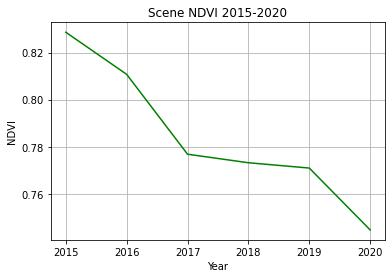

In [4]:
# NDVI=(NIR-Red)/(NIR+Red) # src: https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index
# ["B2", "B3", "B4", "B5", "B6", "B7", "pixel_qa"] 
# B4 = red = bands[2]        # B5 = NIR = bands[3]

# func: specify a year. Depending on 'mode' param:calc summary NDVI for whole image or return an array
def calc_img_NDVI(img_yr, data_dict, mode):
    Red, NIR = data_dict[img_yr][0], data_dict[img_yr][1]
    NDVI=(NIR-Red)/(NIR+Red)
    if mode == 'summary':
        img_NDVI = np.nanmean(NDVI) # ignore Nan's discrepances btwn bands
        return img_NDVI
    if mode == 'array':
        return NDVI
    else:
        print('unspecified mode of NDVI')
        return

# loop through to make yr and value lists
years, NDVIs = [], []
for yr in tiffs:
    NDVIs.append(calc_img_NDVI(yr[:-4],sat_img_sts, 'summary'))
    years.append(yr[:-4])

# mk plot
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
ax.plot(years, NDVIs, '-g')
ax.set_title('Scene NDVI 2015-2020')
ax.set_xlabel('Year')
ax.set_ylabel('NDVI')
plt.grid(True)
# ax.set_ylim(-1, 1)
plt.show()

# save fig
fig.savefig('NDVI_2015_2020.png', dpi=600, bbox_inches='tight')
# save csv
with open('NDVI_2015_2020.csv', 'w') as f:
    f.write("{}, {}\n".format('Year', 'mean_NDVI'))  # title
    for i in range(len(years)):                      # data
        f.write("{}, {}\n".format(years[i], NDVIs[i]))

##### 2. Within the area dictated by the shapefile (‘area_of_interest.shp’) provided, look at the time series of NDVI for the sample pixels within that area. Are you seeing a pattern? If so, what is the explanation for it? (your code should produce a time series line graph plotting each pixel as a line)

In [5]:
aoi = gpd.read_file(os.path.join(data_dir,'area_of_interest.shp'))
rast_15 = rasterio.open(os.path.join(data_dir,'2015.tif'))

print('AOI Proj: ', aoi.crs)            # planar proj crs
print('rast 2015 Proj: ', rast_15.crs)  # globe gcrs

# globe --> planar proj for mapping purposes... but don't want to resample 30m LandSAT data by nearest neighbour,
# so planar to global it is

aoi_proj = aoi.copy()
aoi_proj = aoi_proj.to_crs('EPSG:4326') # reporj
print('\n new AOI Proj: ', aoi_proj.crs)           

aoi_proj.to_file('area_of_interest_EPSG_4326.shp')  

AOI Proj:  epsg:3857
rast 2015 Proj:  EPSG:4326

 new AOI Proj:  EPSG:4326


2015.tif


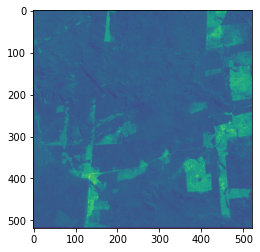

2016.tif


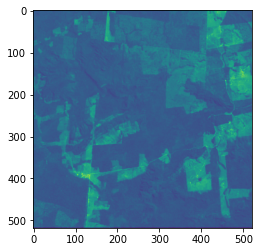

2017.tif


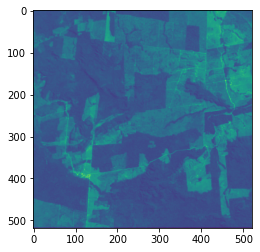

2018.tif


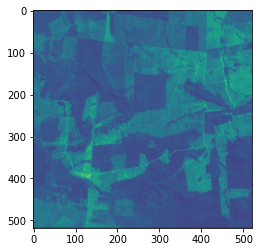

2019.tif


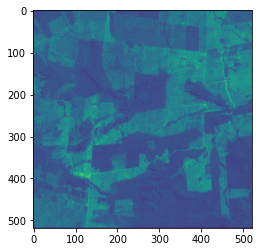

2020.tif


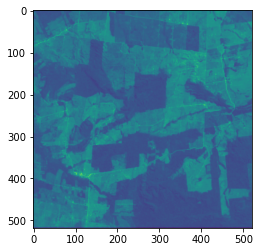

In [6]:
aoi = fiona.open(os.path.join(data_dir,'area_of_interest_EPSG_4326.shp'))
shapes = [feature["geometry"] for feature in aoi]  # https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html
aoi_sat_img_sts = {}

# for each file, read, clip, put into new dictionary
for file in tiffs:
    with rasterio.open(os.path.join(data_dir,file)) as raster:
        # # vis interpretation
        print(file)
        show(raster.read(2))
        
        # clip the raster down
        out_image, out_transform = rasterio.mask.mask(raster, shapes, crop=True)
        out_meta = raster.meta # for saving file
        
#         plt.imshow(out_image[2,:,:])  #  clip is a little array shape = (7, 34, 34)
        aoi_sat_img_sts[file[:-4]] = out_image[2:4,:,:] # pop w only bands 2,3, all x,y dims    

# Up to here was 90 minutes

c:\programdata\anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
c:\programdata\anaconda3\envs\thesis\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


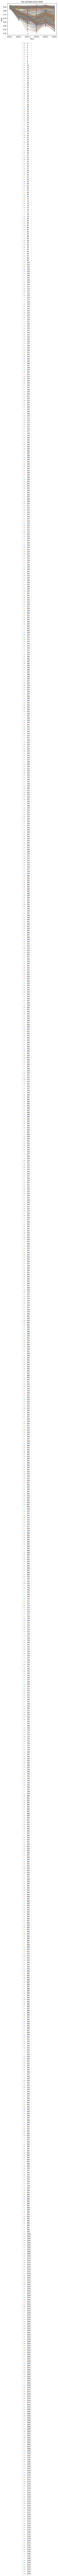

In [7]:
aoi_sat_img_sts['2015'].shape  # (2, 34, 34)
cell_list = []
count = 0 # for each year

for yr in tiffs:  # for each year in the AOI sat img dictionary
    NDVI = calc_img_NDVI(yr[:-4],aoi_sat_img_sts, 'array') # return the array
#     print(NDVI.shape)    
    NDVI = list(NDVI.flatten()) # easier to iterate over than nested for row, for col - shape not important
#     print(len(NDVI)) # 1156
    
    # put each cell into a df. col for each cell
    for cell in range(len(NDVI)):  # for each cell in a year
        if count == 0: # if first loop
            cell_list.append([NDVI[cell]]) # create a list of lists with 2015's numerical value as a list (so can append to it later)
        else:
            cell_list[cell].append(NDVI[cell]) # append onto each inner list
                
    count = count+1
    
# do not append to an existing df, as it gets slower and slower due to reallocating mem each time df inc in size.
# only make df once
headers = [str(i) for i in list(range(2015, 2021))] # stringify each number between 2015-2021
cell_df = pd.DataFrame(cell_list, columns=[headers])
# cell_df.head()


# ----- PLOT
# cell_df.shape[0] #1156 - legend will be mess
# would like to make x axis prettier but I don't think this graph is fit for external/report display

cell_df_T = cell_df.T        # transpose (swap x-y axes so below works)

cell_df_T.plot.line(marker='.', lw='0.5', title='Per cell NDVI 2015-2020')
plt.xlabel('Years')
plt.ylabel('NDVI')
plt.legend(bbox_to_anchor=(0.5, -0.2)) # not useful, just move out of the way. Can remove leg, but needs to be  plt.axes obj
plt.show()

<b>Answer to Q2) -</b> 

Well, there is a overarching decrease in terms of NDVI score per-cell. Based solely on line density; 3 patterns. 

1) Stable NDVI (~0.85)

2) Decreasing yearly, increases in 2019, but otherwise decreasing

3) all other cases which lean to greater/lesser extents of the two above patterns. Maybe a couple edge cases like 2017 lowest cell

Explanation: given the job role, you would suspect deforestation. Unfortunately, I believe a picture paints a thousand words and earlier on in the process I rasterio's 'show'ed the Red and NIR bands to check data was being read in correctly. In both bands, it can be seen each year that there is the general decrease in forested area. However what I did not notice from the map visualisations, and only saw in this line plot, was the slight increase in NDVI for many cells in 2019. 

<b>Took ~ +45mins</b>

#### 3. Only looking at the NDVI values for individual pixels of the entire 2020 raster, can you propose a simple machine learning method to separate vegetated pixels from non-vegetated pixels? Is there any challenge in order to completely separate such pixels? (your code should visualise how the pixels are separated when using NDVI as the feature)


SVM would be the best as 'flexible' classif boundary tube allowing minor misclassifications to preserve more distinct correct cases ... but benefits from having more attribs/dimensions than just a singular NDVI (NDVI, Red, NIR, other bands)

Similarly DBSCAN would be useful if using Red and NIR bands, but solely NDVI is wanted


Do I do supervised learning (1: labelling <b>v manually intensive</b> train:test datasets, 2:arbitrary quickly make train:test based on a threshold NDVI value for veg/non-veg from the wider Lit... 3: Do unsupervised learning and let alg decide?)

Not unsup. Just because I think there are two classes, don't know how many spectrally distinct classes there would be (water, bare earth, light veg, dense veg etc etc) nor their similarity to each other.

ok - lets do UNSUPERVISED, specifying n classes, as values I have in 2020, Wikipedia suggests these would be all vegetated

"<i>Negative values of NDVI (values approaching -1) correspond to water. Values close to zero (-0.1 to 0.1) generally correspond to barren areas of rock, sand, or snow. Lastly, low, positive values represent shrub and grassland (approximately 0.2 to 0.4), while high values indicate temperate and tropical rainforests (values approaching 1)</i>" - [Wiki NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index)


I am making the fundamental assumption that there are only two main classes within the scene. This is supported by the values I do have, would all be classed as vegetated according to Wikipedia.
Based on values, maybe there are mostly two main classes of light and dense veg. The gentle decrease in pixels is likely due to mixed pixel effect (~30m res) rather than binary, bare earth or forest which is happenning on the ground (from glancing at rasterio's show). Unsup classification to find distinct threshold of NDVI


c:\programdata\anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


(518, 520)
520
(268840,)
(268840,)
268840


No handles with labels found to put in legend.


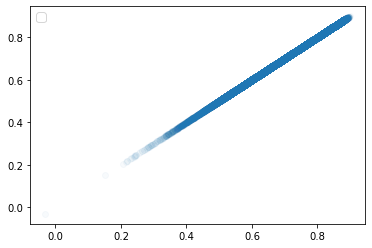

In [12]:
data = calc_img_NDVI('2020',sat_img_sts, 'array') # return the array
print(data.shape)
print(np.count_nonzero(np.isnan(data)))  # 520 real-valued cells... should be 268840 real valued

indices = np.arange(data.shape[0]*data.shape[1]).reshape(data.shape[0],data.shape[1]) # array of indexes (518, 520)
data_arr = data[np.logical_not(np.isnan(data))] # rm nan's... makes 1d array
indices_arr = indices[np.logical_not(np.isnan(data))] # rm same nan's  
print(data_arr.shape)        # 518* 520 = 269360  != 268840
print(indices_arr.shape)    
data_list = list(data_arr.flatten())
print(len(data_list))  # visualised in a loop, these are real values
from scipy.stats import norm

x_axis = np.arange(min(data_list),max(data_list),0.001)
fig = plt.figure()
# x_axis = np.arange(-1,1,0.001)                            # examine density/distrib
# plt.plot(x_axis, norm.pdf(x_axis,np.mean(data_list),np.std(data_list)), label ="NDVIs")    # prob dist smoothes, only offers mode, single peak
plt.scatter(data_list, data_list, alpha=0.03)
plt.legend(loc = "best",fontsize = 'large')
plt.show()

In [9]:
# checking n values when changing from 2d array, to 1d array, to list
print(data.shape)
data_reshaped = data_arr.reshape(-1,520)
print(data_reshaped.shape)       # not doing what I want.  diff btwn 517 and 518
data_reshaped

print(np.count_nonzero(data_reshaped))  # 268840 values
print(np.count_nonzero(data_arr))      # 268840 values
 
# np.count_nonzero(n_clust) # 271

(518, 520)
(517, 520)
268840
268840


In [10]:
# https://www.analyticsvidhya.com/blog/2021/04/k-means-clustering-simplified-in-python/

kmeans = KMeans(2) #n clust
data_list_df = pd.DataFrame(data_list, columns=['NDVI'])  # when doing kmeans.fit as a 2d array 'data_reshaped', only 1 axis getting read...n517
kmeans.fit(data_list_df)
n_clust = kmeans.fit_predict(data_list_df)
print(np.array(np.unique(n_clust, return_counts=True)).T)  # return unique vals and their counts

113678


array([[     0, 155162],
       [     1, 113678]], dtype=int64)

In [12]:
# repeating, with min-max scaled data to get more range. Not bothering with stdevs... noticeable effect, more cells in class 0 than when non-scaled
kmeans_std = KMeans(2)
data_std = MinMaxScaler().fit_transform(data)
data_std = list(data[np.logical_not(np.isnan(data))].flatten()) # doing all the rm na's -> make list here as MinMaxScaler needs 2darray
data_list_df_std = pd.DataFrame(data_std, columns=['NDVI'])
kmeans_std.fit(data_list_df_std)
n_clust_std = kmeans.fit_predict(data_list_df_std)
print(np.array(np.unique(n_clust_std, return_counts=True)).T)   # return unique vals and their counts

array([[     0, 154740],
       [     1, 114100]], dtype=int64)

In [13]:
# a range of better ways to vis the separation, src: https://cran.r-project.org/web/packages/Ckmeans.1d.dp/vignettes/Ckmeans.1d.dp.html

### Stopped as nearing 24hr before Deadline.

So, while I have a basic 2-class classifier, I can't yet query the results to see if it is sensible.

Was going to plot the output of class 1 and class 2 to visually see if it looked similar to darker/lighter forested/bare areas in the rasterio image. (To see if the two classes I think are present in the image have been detected)

the indexing and data reshaping is to turn a list (Nan values removed) back into a 2d array, which can then be plotted. I know it can be done, but haven't figured out how just yet

<b>3hrs</b>

In [63]:
indexes = list(indices_arr.flatten()) #mk list

# new_array = 

for i in indexes:
    print(n_clust[i])  # returns if 0 or 1    # # n_clust.shape # (268840,)
    

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
1
0
0
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
0
1
1
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0


1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
1
1
1
1
1
1
0
0
1
1
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
1
0
0
0
0
0
0
0
0
0
1
1
0
0
1
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
1
1
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
0
0
1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
0
0
1
1
1
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
1
1
1
1
1
1


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
0
0
0
1
0
0
1
1
1
1
1
1
0
0
1
1
1
1
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
0
0
1
1
0
0
0
0
1
1
1
1
1
1
1
0
1
0
0
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
1
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
0
0
0
1
0
0
0
0
0
0
0
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0


1
1
1
1
1
1
1
0
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
1
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
1
1
1
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
1
1
1
1
1
1
1
0
1
1
0
0
0
1
0
1
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
0
0
0
0
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
1
0
0
0
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
1
1
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
0
1
1
1
1
0
0
0
1
0
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
0
0
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
1
1
0
0
0
0
1
0
0
0
0
0
0
0
0
1
1
0
0
1
1
1
1
0
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0


1
1
1
1
1
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
1
1
0
0
0
1
1
1
0
0
0
0
1
1
0
1
1
1
1
1
1
1
1
0
1
0
0
1
1
1
1
1
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
0
1
1
1
0
0
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
1
1
1
1
1
1
1
0
0
0
0
0
0
0


0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
0
0
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
0
0
0
0
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
1
0
0
1
1
1
1
1
0
0
0
1
1
1
1
1
0
0
0
0
1
1
1
1
1
1
0
0
0
0
1
1
0
0
0
1
1
0
0
0
0
1
1
1
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
0
1
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0


1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
0
0
0
0
1
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
1
0
1
1
1
1
1
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
1
1
1
1
1
0
1
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
1
0
0
0
0
1
1
1
1
1
0
1
1
1
0
1
1
1
1
0
0
0
0
0
0
1
1
1
1
1
1
1
0
0
0
0
0
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
1
1
1
1
1
1
1
1
0
1
0
1
0
0
0
0
0
0
0
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
1
1
1
1
1
0
0
0
0
0
0
1
1
1
1
1
1


1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
1
1
0
0
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
1
0
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
1
0
0
0
0
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
1
1
1
1
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0


1
1
1
1
1
1
0
0
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
1
1
1
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
1
1
0
0
0
1
1
1
0
0
0
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
1
0
0
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
0
1
0
0
0
0
1
1
1
1
1
1
1
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
0
1
0
0
0
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
0
1
1
0
0
0
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
0
0
0
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1


0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
1
1
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
1
1
1
0
0
0
0
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
0
1
1
1
1
1
0
0
0
0
0
0
0
0
1
1
1
0
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
0
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
0
0
1
0
1
1
0
1
1
1
1
0
0
1
0
0
0
0
1
1
1
1
1
1
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
1
1
1
1
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
0
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
1
1
1
1
0
1
1
1
0
0
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
1
1
0
1
0
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0


1
1
1
0
1
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
1
0
0
0
1
1
1
1
1
0
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
0
0
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
0
0
0
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
1
1
0
0
0
0
0
0
0
0
1
1
1
0
1
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


1
1
0
0
0
0
0
0
1
1
1
1
1
0
0
1
1
1
1
1
1
1
0
0
1
1
1
1
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
1
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
1
1
1
1


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
1
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
1
0
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
0
1
0
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
0
0
0
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0


0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1


KeyboardInterrupt: 